In [1]:
import cv2 
from google.colab.patches import cv2_imshow
import numpy as np
import os
import pandas as pd
import glob
import random

In [2]:
#빈 캔버스 만들기
def init() : 
  blank = np.zeros([512,512],dtype=np.uint8)
  blank.fill(0)
  blank = cv2.resize(blank,(512,512))
  
  return blank
  
def drawNp(img):
  blank = init()
  #print(img.shape[0])
  for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
      if img[i][j] == 1 :
        blank[i][j] = 255

  return blank

In [3]:
def map2Image(minX,minY,maxX,maxY,csv_file):

  inputImage = np.zeros([512,512], dtype=np.uint8)

  for i in range(0,csv_file.shape[0]):
    x = csv_file.loc[i][0]
    y = csv_file.loc[i][1]

    mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
    mapY = int(round(np.interp(y,[minY,maxY],[0,500])))
    inputImage[mapX][mapY] = 1

  outputImage = drawNp(inputImage)

  rotImage = np.rot90(outputImage)

  return rotImage

def coorMaxMin(file):
  minX, minY = (file.loc[0][0],file.loc[0][1])
  maxX, maxY = (file.loc[0][0],file.loc[0][1])
  for i in range(0,file.shape[0]):
    x = file.loc[i][0]
    y = file.loc[i][1]
    if x > maxX :
      maxX = x
    if x < minX :
      minX = x
    if y > maxY :
      maxY = y
    if y < minY :
      minY = y
  return minX, minY, maxX, maxY


In [4]:
def map2Image_noise(minX,minY,maxX,maxY,csv_file):

  inputImage = np.zeros([512,512], dtype=np.uint8)

  randomList = set()
  while len(randomList) < int(csv_file.shape[0]/7):
    randomList.add(random.randint(0,csv_file.shape[0]))

  randomList=list(randomList)
  dicisionList = [1,-1]

  for i in range(0,csv_file.shape[0]):

    try:
      randomList.index(i)
      
      r = random.uniform((minX-maxX)/40,(minX-maxX)/20)
      D = random.choice(dicisionList)

      x = csv_file.loc[i][0]-(D*r)
      y = csv_file.loc[i][1]-(D*r)

      mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
      mapY = int(round(np.interp(y,[minY,maxY], [0,500])))
      inputImage[mapX][mapY] = 1

    except:
      x = csv_file.loc[i][0]
      y = csv_file.loc[i][1]

      mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
      mapY = int(round(np.interp(y,[minY,maxY], [0,500])))
      inputImage[mapX][mapY] = 1


  outputImage = drawNp(inputImage)

  rotImage = np.rot90(outputImage)

  return rotImage

In [5]:
def PrecisionAndRecall(decodeImage,OriginalImage,csvFile,Threshold):

  blank = np.zeros([512,512],dtype=np.uint8)
  blank.fill(0)
  blank = cv2.resize(blank,(512,512),1)

  for x in range(0,512):
    for y in range(0,512):
      if decodeImage[x][y] > Threshold :
      
        blank[x][y] = OriginalImage[x][y] * 255

  inputImage = np.zeros([512,512], dtype=np.uint8)
  blankRot = np.rot90(blank)
  blankRot = np.rot90(blankRot)
  blankRot = np.rot90(blankRot)
  minX,minY,maxX,maxY = coorMaxMin(csvFile)
  FN = TP = TN = FP = 0
  for i in range(0,csvFile.shape[0]):
    x = csv_file.loc[i][0]
    y = csv_file.loc[i][1]

    mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
    mapY = int(round(np.interp(y,[minY,maxY],[0,500])))
    inputImage[mapX][mapY] = 1

    if inputImage[mapX][mapY]==1 and blankRot[mapX][mapY] == 255:
      #print(i,csvFile.loc[i][3])
      if csvFile.loc[i][3] == False:
        FN = FN + 1
      else : 
        TN = TN + 1
    else:
      #print(i,"erased : ",csv_file.loc[i][3])
      if csvFile.loc[i][3] == True:
        TP = TP + 1
      else:
        FP = FP + 1


  outputImage = drawNp(inputImage)

  rotImage = np.rot90(outputImage)
  #print(blank)
  cv2_imshow(blank)
  cv2_imshow(rotImage)

  print("FN : ",FN,"TN : ",TN,"TP : ",TP,"FP : ",FP)

  return FN,TN,TP,FP



In [6]:
############################
######## Image Load ########
############################

import os, cv2, glob
import numpy as np

saveDir = "/content/drive/My Drive/WayPoint/FullData_Image/432-Image/Test-Image-noise/Reconstruct/"
#dataDir = "/content/drive/My Drive/WayPoint/FullData_Image/432-Image/"

dataDir = "/content/drive/My Drive/WayPoint/직접찍은데이터/"


In [7]:
SIZE = 512
def GetImage( path ):
	img = cv2.imread( path, 1 )
	resized = cv2.resize( img, ( SIZE, SIZE ), 3)
	converted = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
	converted = np.expand_dims(converted, axis=-1)
	return converted

X_trainDir = dataDir
Y_trainDir = dataDir + 'Noise/'# + 'Val/'


In [27]:
X_train, Y_train = [ ], [ ]

os.chdir( X_trainDir )
#X_trainFiles = glob.glob( '*png' )
X_trainFiles = glob.glob( '*csv' )
X_trainFiles = np.sort(X_trainFiles)
#print(X_trainFiles)

for f in X_trainFiles:
	csv_file = pd.read_csv(f, names=["lat","long","num"], header=None)
	minX,minY,maxX,maxY = coorMaxMin(csv_file)
	resultImage = map2Image_noise(minX,minY,maxX,maxY,csv_file)

	#X_train.append( GetImage( f ) )
	X_train.append(resultImage)

os.chdir( Y_trainDir )
#Y_trainFiles = glob.glob( '*png' )
Y_trainFiles = glob.glob( '*csv' )
Y_trainFiles = np.sort(Y_trainFiles)
#print(Y_trainFiles)
for f in Y_trainFiles:
	csv_file = pd.read_csv(f, names=["lat","long","num","Noise"], header=None,skiprows=1)
	minX,minY,maxX,maxY = coorMaxMin(csv_file)

	resultImage = map2Image(minX,minY,maxX,maxY,csv_file)
 
	#Y_train.append( GetImage( f ) )
	Y_train.append(resultImage)


In [9]:
print(np.shape(X_train))
print(np.shape(Y_train))

(56, 512, 512)
(56, 512, 512)


In [10]:
## Load Test Data ##
testDir = dataDir + 'Val/Noise/'

X_test = [ ]

os.chdir( testDir )
testFiles = glob.glob( '*csv' )
for f in testFiles:
	csv_file = pd.read_csv(f, names=["lat","long","num","Noise"], header=None, skiprows=1)
	minX,minY,maxX,maxY = coorMaxMin(csv_file)

	resultImage = map2Image(minX,minY,maxX,maxY,csv_file)
	X_test.append(resultImage)

In [11]:
## Resize Images for CNN ##
X_train, Y_train = np.array( X_train ), np.array( Y_train )
X_test = np.array( X_test )

X_train = X_train.astype( 'float32' ) / 255.
Y_train = Y_train.astype( 'float32' ) / 255.
X_test = X_test.astype( 'float32' ) / 255.

print( X_train.shape, Y_train.shape, X_test.shape )

X_train = np.reshape( X_train, ( len( X_train ), SIZE, SIZE, 1 ) )
Y_train = np.reshape( Y_train, ( len( Y_train ), SIZE, SIZE, 1 ) )
X_test = np.reshape( X_test, ( len( X_test ), SIZE, SIZE, 1 ) )

print( 'train shape (X, Y): ({},{})'.format( X_train.shape, Y_train.shape ) )
print( 'test shape (X): ({})'.format( X_test.shape ) )

(56, 512, 512) (56, 512, 512) (10, 512, 512)
train shape (X, Y): ((56, 512, 512, 1),(56, 512, 512, 1))
test shape (X): ((10, 512, 512, 1))


In [12]:
#############################
###### Construct Model ######
#############################

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate



In [13]:
 ## Hyper Parameter ##
acti, pad = 'relu', 'same'

## Input Image ##
input_img = layers.Input(shape=(512, 512, 1))

# Encoding #
conv1 = Conv2D( 128, ( 3, 3 ), activation = 'relu', padding = 'same' )( input_img )
pool1 = MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv1 )

conv2 = Conv2D( 64, ( 3, 3 ),  activation = 'relu', padding = 'same' )( pool1 )
pool2 = MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv2 )

conv3 = Conv2D( 32, ( 3, 3 ), activation = 'relu', padding = 'same' )( pool2 )
pool3 = MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv3 )


# Decoding #
conv4 = Conv2D( 32, ( 3, 3 ), activation = 'relu', padding = 'same' )( pool3 )
up1 = UpSampling2D( ( 2, 2 ) )( conv4 )

merge1 = concatenate([conv3,up1])
conv5 = Conv2D( 64, ( 3, 3 ), activation = 'relu', padding = 'same' )( merge1 )
up2 = UpSampling2D( ( 2, 2 ) )( conv5 )

#merge2 = concatenate([conv2,up2])
conv6 = Conv2D( 128, ( 3, 3 ), activation = 'relu', padding = 'same' )( up2 )
up3 = UpSampling2D( ( 2, 2 ) )( conv6 )


decoded = Conv2D( 1, ( 3, 3 ), activation = 'sigmoid', padding = 'same' )( up3 )

In [14]:
## Compile
Unet = keras.Model(input_img, decoded)
Unet.summary()

Unet.compile( optimizer = 'adam', loss = 'binary_crossentropy' )


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 128 1280        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 128 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 73792       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [15]:
EPOCH = 30
BATCH = 10
SHUFFLE = True

history = Unet.fit( Y_train, X_train, epochs = EPOCH, batch_size = BATCH, shuffle = SHUFFLE )


Epoch 1/30
6/6 [==============================] - 2s 297ms/step - loss: 0.5916
Epoch 2/30
6/6 [==============================] - 1s 182ms/step - loss: 0.0524
Epoch 3/30
6/6 [==============================] - 1s 183ms/step - loss: 0.0899
Epoch 4/30
6/6 [==============================] - 1s 181ms/step - loss: 0.0532
Epoch 5/30
6/6 [==============================] - 1s 182ms/step - loss: 0.0177
Epoch 6/30
6/6 [==============================] - 1s 182ms/step - loss: 0.0146
Epoch 7/30
6/6 [==============================] - 1s 182ms/step - loss: 0.0123
Epoch 8/30
6/6 [==============================] - 1s 184ms/step - loss: 0.0111
Epoch 9/30
6/6 [==============================] - 1s 182ms/step - loss: 0.0108
Epoch 10/30
6/6 [==============================] - 1s 184ms/step - loss: 0.0095
Epoch 11/30
6/6 [==============================] - 1s 181ms/step - loss: 0.0090
Epoch 12/30
6/6 [==============================] - 1s 182ms/step - loss: 0.0086
Epoch 13/30
6/6 [==============================] 

In [16]:
decoded_img = Unet.predict( X_test )

In [17]:
print(np.shape(decoded_img))

(10, 512, 512, 1)


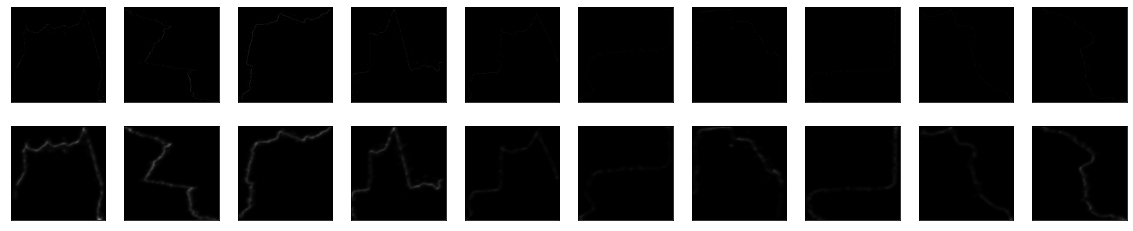

In [18]:
import matplotlib.pyplot as plt

os.chdir( saveDir )
n = 10
plt.figure( figsize = ( 20, 4 ) )
for i in range( n ):
	ax = plt.subplot( 2, n, i + 1 )
	plt.imshow( X_test[i].reshape( SIZE, SIZE) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

	ax = plt.subplot( 2, n, n + i + 1 )
	plt.imshow( decoded_img[i].reshape( SIZE, SIZE))
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

plt.show()

In [19]:
import numpy as np
blank = np.zeros([512,512],dtype=np.uint8)
blank.fill(255)
blank = cv2.resize(blank,(512,512),1)

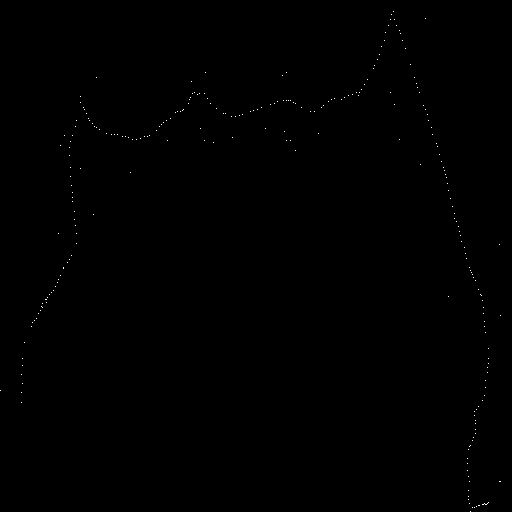

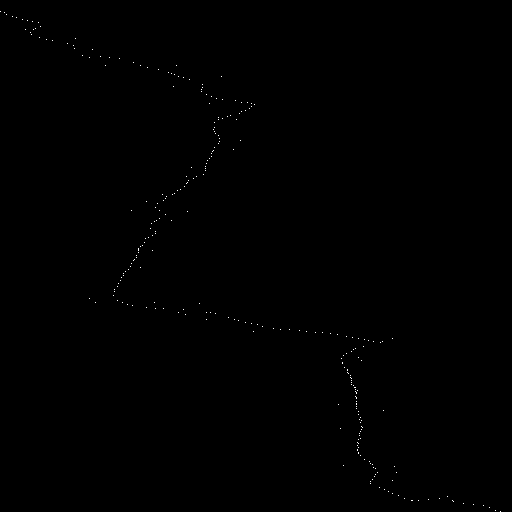

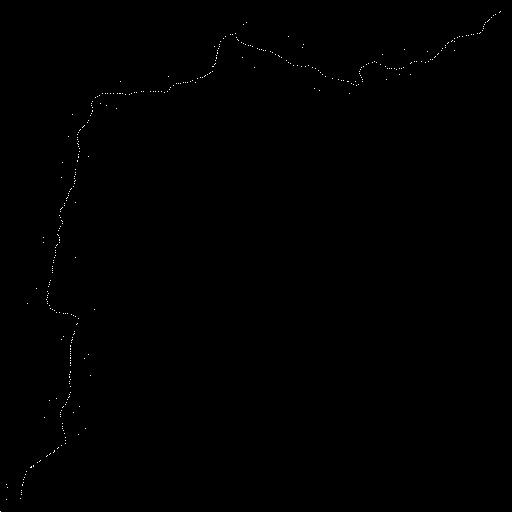

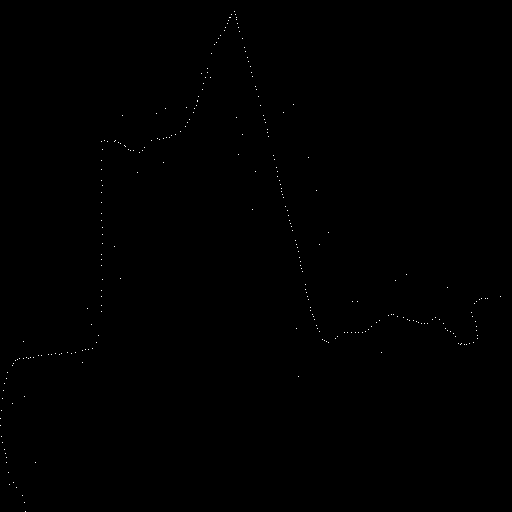

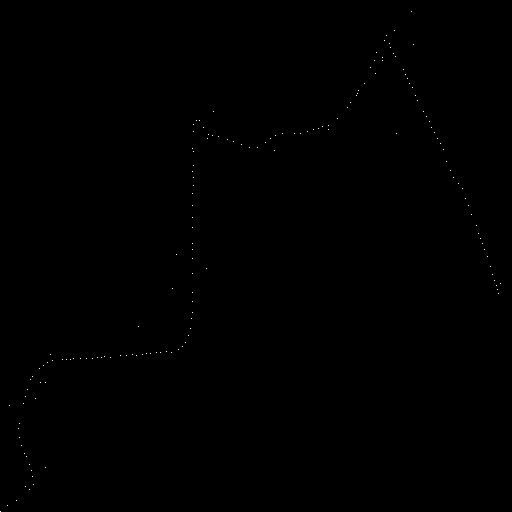

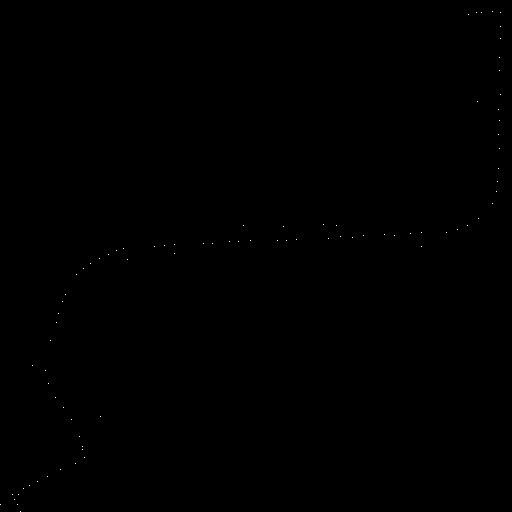

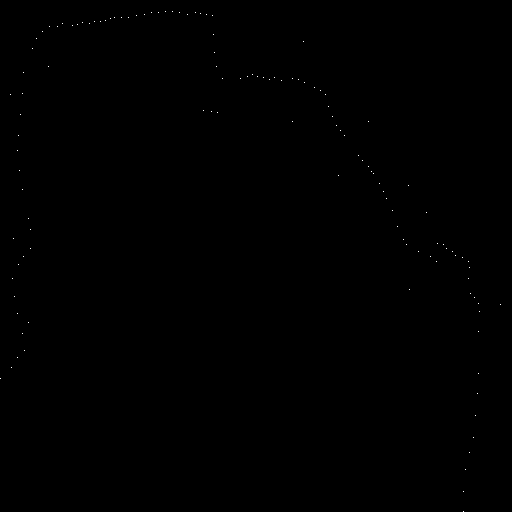

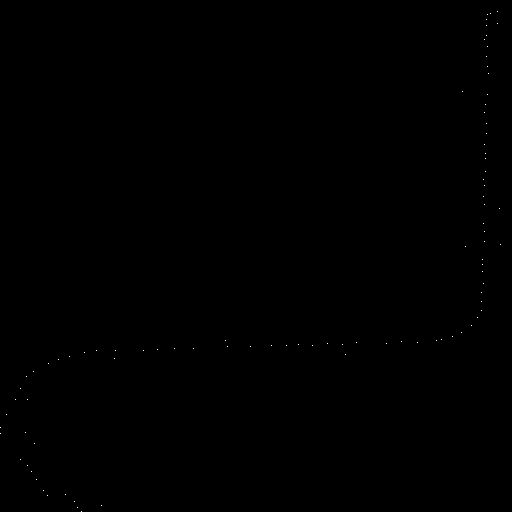

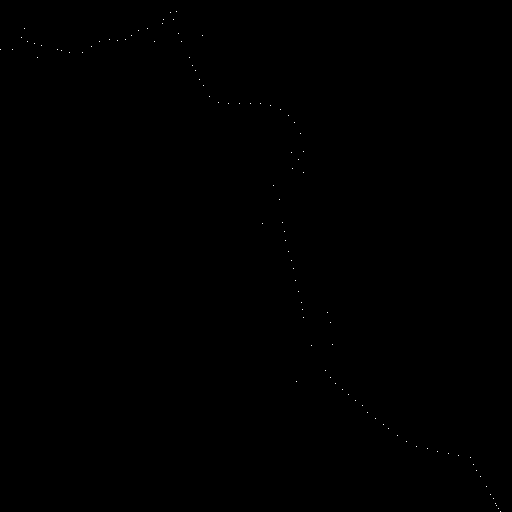

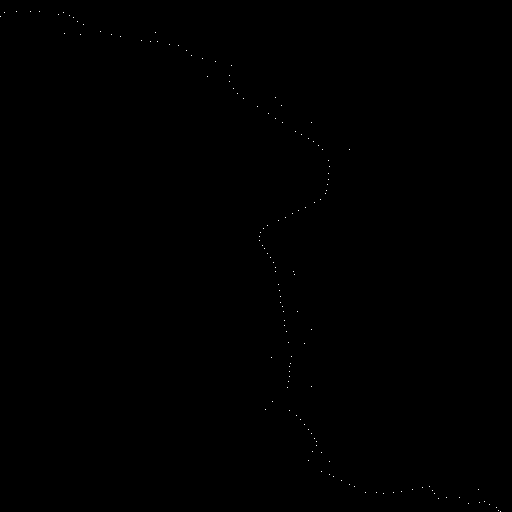

In [28]:
from google.colab.patches import cv2_imshow

n = 10
for i in range( n ):
  resized = X_test[i].reshape(SIZE, SIZE)
  #print(resized*255)
  for x in range(0,512):
    for y in range(0,512):
      blank[x][y] = resized[x][y] * 255

  cv2_imshow(blank)
  #print(" ")

In [26]:
"""
from google.colab.patches import cv2_imshow


blank = np.zeros([512,512],dtype=np.uint8)
blank.fill(0)
blank = cv2.resize(blank,(512,512),1)

n = 10
for i in range( n ):
  resized = decoded_img[i].reshape(SIZE, SIZE)
  X_test_image = X_test[i].reshape(SIZE,SIZE)
  print(resized)
  for x in range(0,512):
    for y in range(0,512):
      if resized[x][y] > 0.009 :
      
        blank[x][y] = X_test_image[x][y] * 255
        

  cv2_imshow(blank)
  blank.fill(0)
"""

'\nfrom google.colab.patches import cv2_imshow\n\n\nblank = np.zeros([512,512],dtype=np.uint8)\nblank.fill(0)\nblank = cv2.resize(blank,(512,512),1)\n\nn = 10\nfor i in range( n ):\n  resized = decoded_img[i].reshape(SIZE, SIZE)\n  X_test_image = X_test[i].reshape(SIZE,SIZE)\n  print(resized)\n  for x in range(0,512):\n    for y in range(0,512):\n      if resized[x][y] > 0.009 :\n      \n        blank[x][y] = X_test_image[x][y] * 255\n        \n\n  cv2_imshow(blank)\n  blank.fill(0)\n'

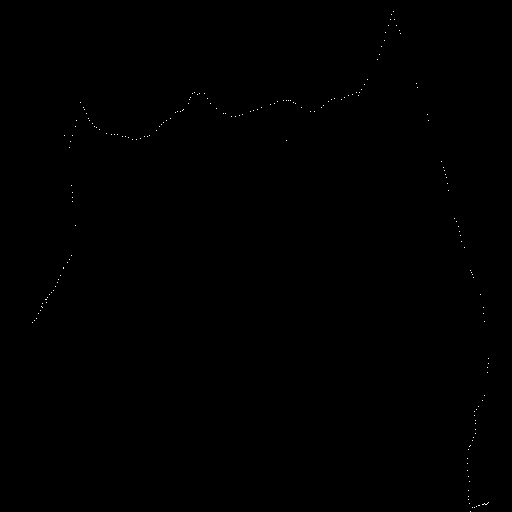

In [30]:

blank = np.zeros([512,512],dtype=np.uint8)
blank.fill(0)
blank = cv2.resize(blank,(512,512),1)

hit = []
resized = decoded_img[0].reshape(SIZE, SIZE)
X_test_image = X_test[0].reshape(SIZE,SIZE)
#print(resized)
for x in range(0,512):
  for y in range(0,512):
    if resized[x][y] > 0.009:
      hit.append(resized[x][y])
      
      
      blank[x][y] = X_test_image[x][y] * 255

cv2_imshow(blank)     

In [29]:
os.chdir( testDir )
testFiles = glob.glob( '*csv' )

for f in testFiles[0:3]:
  print(testFiles[0])
  csv_file = pd.read_csv(f, names=["lat","long","num","Noise"], header=None, skiprows=1)
  #print(csv_file)

20160411100630_100_OA3620_noise.csv
20160411100630_100_OA3620_noise.csv
20160411100630_100_OA3620_noise.csv


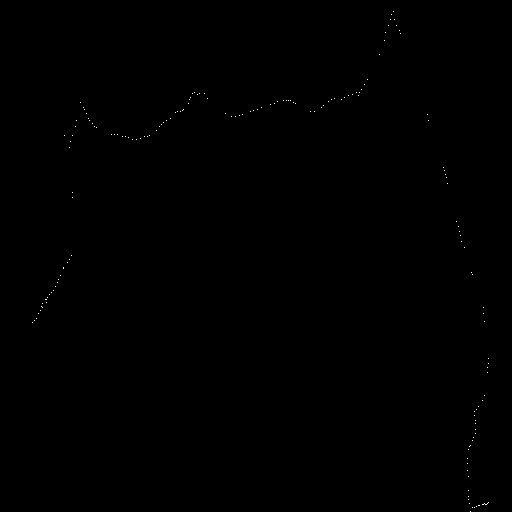

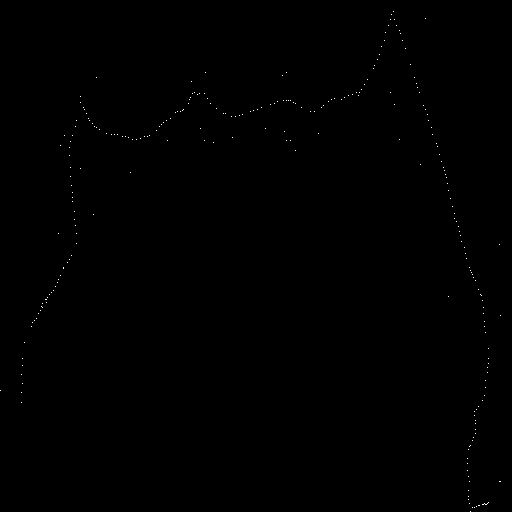

FN :  175 TN :  6 TP :  32 FP :  65


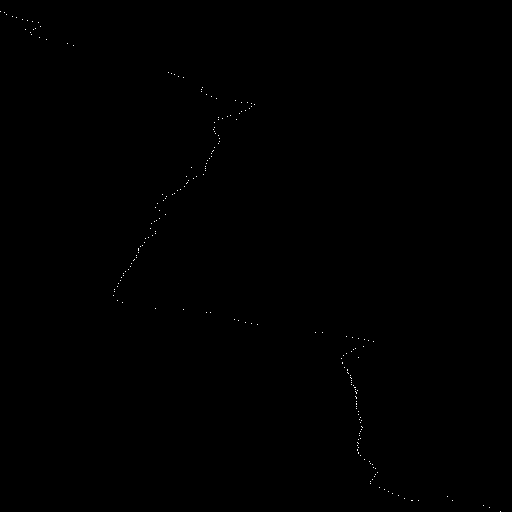

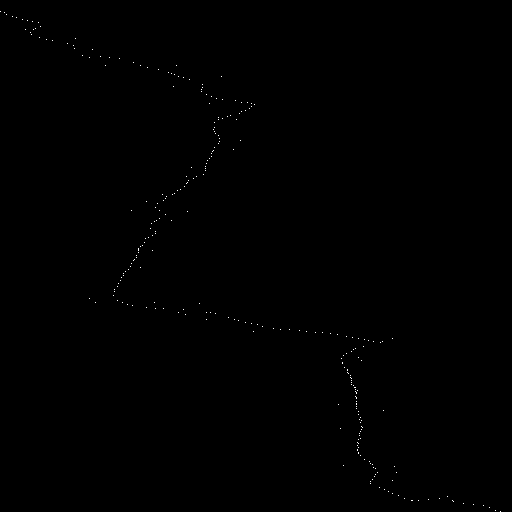

FN :  219 TN :  7 TP :  34 FP :  34


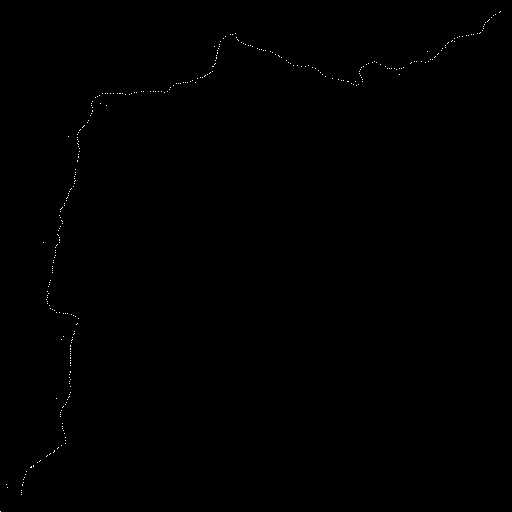

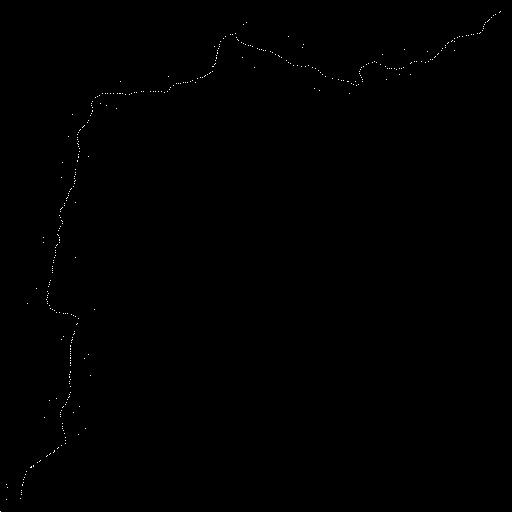

FN :  358 TN :  21 TP :  38 FP :  2


In [25]:
for i in range(0,3):
  csv_file = pd.read_csv(testFiles[i], names=["lat","long","num","Noise"], header=None, skiprows=1)
  FN,TN,TP,FP = PrecisionAndRecall(decoded_img[i].reshape(SIZE,SIZE),X_test[i].reshape(SIZE,SIZE),csv_file,0.0103)